In [ ]:
# Import required libraries for single-cell ATAC-seq analysis
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.sparse
import scipy.cluster.hierarchy as shc
from scipy import stats
from scipy.sparse import csr_matrix, hstack
import os
import anndata
import time
import SEACells
from matplotlib.colors import LinearSegmentedColormap

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['font.family'] = 'sans-serif' 

# Set random seed for reproducibility
np.random.seed(1966)

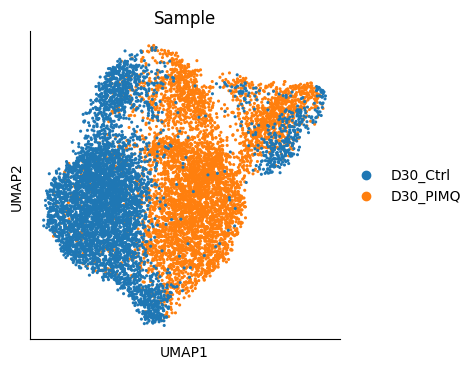

In [ ]:
# Define timepoint and input directory paths
timepoint = 'D30'
sample_type = 'D30'

input_dir = '../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_nonredundantpeakset/'
data_dir = input_dir + 'seacells/SEACells_export/'

# Load peak count data from sparse matrix format
from scipy.io import mmread
counts = mmread(data_dir + 'peak_counts/counts.mtx')

# Load cell and peak metadata
cells = pd.read_csv(data_dir + 'peak_counts/cells.csv', index_col=0).iloc[:, 0]
peaks = pd.read_csv(data_dir + 'peak_counts/peaks.csv', index_col=0)

# Create peak identifiers in format: chr:start-end
peaks.index = peaks['seqnames'] + ':' + peaks['start'].astype(str) + '-' + peaks['end'].astype(str)

# Create AnnData object from peak count matrix
ad = sc.AnnData(counts.T)
ad.obs_names = cells
ad.var_names = peaks.index

# Add peak annotations to variable metadata
for col in peaks.columns:
    ad.var[col] = peaks[col]
    
# Convert to CSR format for efficient computation
ad.X = ad.X.tocsr()

# Load LSI dimensionality reduction coordinates
ad.obsm['X_svd'] = pd.read_csv(data_dir + 'svd.csv', index_col=0).loc[ad.obs_names, : ].values

# Load and integrate cell metadata
cell_meta = pd.read_csv(data_dir + 'cell_metadata.csv', index_col=0).loc[ad.obs_names, : ]
for col in cell_meta.columns:
    ad.obs[col] = cell_meta[col].values

# Load gene activity scores
gene_scores = pd.read_csv(data_dir + 'gene_scores.csv', index_col=0).T
ad.obsm['GeneScores'] = gene_scores.loc[ad.obs_names, :].values
ad.uns['GeneScoresColums'] = gene_scores.columns.values

# Compute neighbors, UMAP, and clustering
sc.pp.neighbors(ad, use_rep='X_svd')
sc.tl.umap(ad)
sc.tl.leiden(ad)

# Visualize samples in UMAP space
sc.pl.umap(ad, color=['Sample'], vmin='p5', vmax='p95', s=20)

In [ ]:
# Load previously computed SEACell assignments from single-cell peak set
seacell_control = pd.read_excel('../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/seacells/SEACell_control.xlsx')
seacell_pimq = pd.read_excel('../intermediate_outputs3/projects/ArchR_D30_min_NA_max_600_scpeakset/seacells/SEACell_PIMQ.xlsx')

In [ ]:
# Split data by condition and assign SEACell labels
control_ad = ad[ad.obs['Sample'] == sample_type + '_Ctrl']
control_ad.obs['SEACell'] = list(seacell_control['SEACell'])

pimq_ad = ad[ad.obs['Sample'] == sample_type + '_PIMQ']
pimq_ad.obs['SEACell'] = list(seacell_pimq['SEACell'])

In [ ]:
# Merge Control and PIMQ datasets
all_ad = sc.concat([control_ad, pimq_ad])

# Aggregate QC metrics by SEACell for normalization
grouped_df = all_ad.obs.groupby('SEACell')[['TSSEnrichment','ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 
                                             'nMonoFrags', 'nDiFrags', 'nMultiFrags', 'nFrags', 
                                             'ReadsInPeaks','FRIP']].sum().reset_index()

# Calculate number of cells per SEACell
group_size = all_ad.obs.groupby('SEACell').size().reset_index(name='Size')

# Combine aggregated metrics with group sizes
norm_info = grouped_df.merge(group_size, on='SEACell')
norm_info

,SEACell,TSSEnrichment,ReadsInTSS,ReadsInPromoter,ReadsInBlacklist,nMonoFrags,nDiFrags,nMultiFrags,nFrags,ReadsInPeaks,FRIP,Size
0,SEACell-0-0,864.473,63113,242598,30848,398310,201879,104650,704839,682696,29.593026,61
1,SEACell-0-1,818.295,42549,162240,16707,209231,124718,70051,404000,455683,30.552704,53
2,SEACell-1-0,1723.462,104623,396098,54021,657124,333284,173055,1163463,1134815,59.371812,120
3,SEACell-1-1,1991.015,196179,747101,76767,803177,557364,283482,1644023,1955441,72.629604,119
4,SEACell-10-0,924.608,74234,283084,30908,464814,233034,125122,822970,878251,34.579508,64
...,...,...,...,...,...,...,...,...,...,...,...,...
138,SEACell-71-0,1292.360,117265,449583,58309,706720,402568,199622,1308910,1356000,49.257959,93
139,SEACell-8-0,337.289,28489,113562,13136,205565,86791,42457,334813,334088,12.496132,24
140,SEACell-8-1,1282.499,106488,398834,47651,498727,332632,188368,1019727,1211775,52.362941,87
141,SEACell-9-0,382.995,36290,142764,16207,244841,130122,70859,445822,460290,16.025868,31


In [ ]:
# Aggregate Control cells into metacells using SEACell assignments
SEACells_label = 'SEACell'
metacells = control_ad.obs[SEACells_label].astype(str).unique()
metacells = metacells[control_ad.obs[SEACells_label].value_counts()[metacells] > 1]
print("Generating Metacell matrices...")
print("ATAC")
    
# Summarize peak counts by SEACell
control_meta_ad = SEACells.core.summarize_by_SEACell(control_ad, SEACells_label=SEACells_label, summarize_layer="X")

# Reorder SEACells for consistent indexing
control_meta_ad = control_meta_ad[['SEACell-' + str(i) + '-0' for i in range(control_meta_ad.shape[0])], :]

# Aggregate SVD coordinates by averaging across cells in each metacell
svd = pd.DataFrame(control_ad.obsm["X_svd"], index=control_ad.obs_names)
summ_svd = svd.groupby(control_ad.obs[SEACells_label]).mean()
summ_svd = summ_svd.reindex(control_meta_ad.obs_names)
control_meta_ad.obsm["X_svd"] = summ_svd.values

# Aggregate UMAP coordinates by averaging
umap = pd.DataFrame(control_ad.obsm['X_umap']).set_index(control_ad.obs_names).join(control_ad.obs["SEACell"])
umap["SEACell"] = umap["SEACell"].astype("category")
control_mcs = umap.groupby("SEACell").mean()
control_mcs = control_mcs.loc[control_meta_ad.obs.index]
control_meta_ad.obsm['X_umap'] = np.array(control_mcs[[0,1]])

# Aggregate gene activity scores by summing across cells
control_genescores = pd.DataFrame(control_ad.obsm['GeneScores'])
control_genescores.columns = list(control_ad.uns['GeneScoresColums'])
control_genescores.index = control_ad.obs_names
control_genescores = control_genescores.join(control_ad.obs['SEACell']).groupby('SEACell').sum()
control_genescores = control_genescores.loc[control_meta_ad.obs.index]
control_meta_ad.obsm['GeneScores'] = control_genescores
control_meta_ad.uns['GeneScoresColumns'] = list(control_meta_ad.obsm['GeneScores'].columns)

# Calculate total counts per metacell
control_meta_ad.obs['n_counts'] = np.ravel(control_meta_ad.X.sum(axis=1))

# Determine open peaks for Control metacells
SEACells.accessibility.determine_metacell_open_peaks(control_meta_ad,
                                                     peak_set=None,
                                                     low_dim_embedding='X_svd',
                                                     pval_cutoff=1e-2,
                                                     read_len=500,
                                                     n_neighbors=3,
                                                     n_jobs=1)

Generating Metacell matrices...
ATAC


100%|██████████| 72/72 [00:03<00:00, 19.76it/s]


In [ ]:
# Aggregate PIMQ cells into metacells using SEACell assignments
SEACells_label = 'SEACell'
metacells = pimq_ad.obs[SEACells_label].astype(str).unique()
metacells = metacells[pimq_ad.obs[SEACells_label].value_counts()[metacells] > 1]
print("Generating Metacell matrices...")
print("ATAC")
    
# Summarize peak counts by SEACell
pimq_meta_ad = SEACells.core.summarize_by_SEACell(pimq_ad, SEACells_label=SEACells_label, summarize_layer="X")

# Reorder SEACells with PIMQ-specific suffix
pimq_meta_ad = pimq_meta_ad[['SEACell-' + str(i) + '-1' for i in range(pimq_meta_ad.shape[0])], :]

# Aggregate SVD coordinates by averaging across cells in each metacell
svd = pd.DataFrame(pimq_ad.obsm["X_svd"], index=pimq_ad.obs_names)
summ_svd = svd.groupby(pimq_ad.obs[SEACells_label]).mean()
summ_svd = summ_svd.reindex(pimq_meta_ad.obs_names)
pimq_meta_ad.obsm["X_svd"] = summ_svd.values

# Aggregate UMAP coordinates by averaging
umap = pd.DataFrame(pimq_ad.obsm['X_umap']).set_index(pimq_ad.obs_names).join(pimq_ad.obs["SEACell"])
umap["SEACell"] = umap["SEACell"].astype("category")
pimq_mcs = umap.groupby("SEACell").mean()
pimq_mcs = pimq_mcs.loc[pimq_meta_ad.obs.index]
pimq_meta_ad.obsm['X_umap'] = np.array(pimq_mcs[[0,1]])

# Aggregate gene activity scores by summing across cells
pimq_genescores = pd.DataFrame(pimq_ad.obsm['GeneScores'])
pimq_genescores.columns = list(pimq_ad.uns['GeneScoresColums'])
pimq_genescores.index = pimq_ad.obs_names
pimq_genescores = pimq_genescores.join(pimq_ad.obs['SEACell']).groupby('SEACell').sum()
pimq_genescores = pimq_genescores.loc[pimq_meta_ad.obs.index]
pimq_meta_ad.obsm['GeneScores'] = pimq_genescores
pimq_meta_ad.uns['GeneScoresColumns'] = list(pimq_meta_ad.obsm['GeneScores'].columns)

# Calculate total counts per metacell
pimq_meta_ad.obs['n_counts'] = np.ravel(pimq_meta_ad.X.sum(axis=1))

# Determine open peaks for PIMQ metacells
SEACells.accessibility.determine_metacell_open_peaks(pimq_meta_ad,
                                                     peak_set=None,
                                                     low_dim_embedding='X_svd',
                                                     pval_cutoff=1e-2,
                                                     read_len=500,
                                                     n_neighbors=3,
                                                     n_jobs=1)

Generating Metacell matrices...
ATAC


100%|██████████| 71/71 [00:03<00:00, 19.18it/s]


In [ ]:
# Merge Control and PIMQ metacell datasets
ad_norm = sc.concat([control_meta_ad, pimq_meta_ad])

# Add Condition labels based on metacell identifier suffix
ids = list(ad_norm.obs.index)

Condition = []
for id in ids:
    if id.endswith('-0'):
        Condition.append('Control')
    else:
        Condition.append('PIMQ')
        
ad_norm.obs['Condition'] = Condition

# Calculate number of peaks detected per metacell
ad_norm.obs['n_peaks_detected'] = (ad_norm.X > 0).sum(axis=1)

In [ ]:
# Export unnormalized peak counts for DESeq2 differential accessibility analysis
ad_norm.to_df().to_csv('../intermediate_outputs3/DESeq2_files/Unnormalized_non_redundant_D30.tsv', sep='\t')

In [ ]:
# Merge QC metrics and group size information into metacell metadata
ad_norm.obs = ad_norm.obs.merge(norm_info, left_index=True, right_on='SEACell', how='left').set_index('SEACell')

In [ ]:
# Calculate fragments per cell for normalization
ad_norm.obs['FragmentsPerSize'] = ad_norm.obs['nFrags'] / ad_norm.obs['Size']

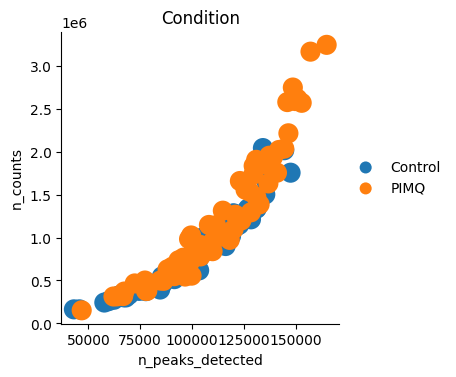

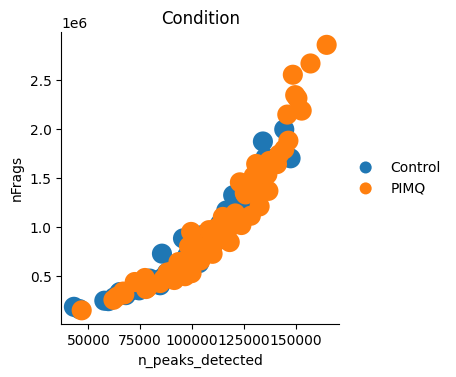

Normalizing data
Log transform with pseudocount 1


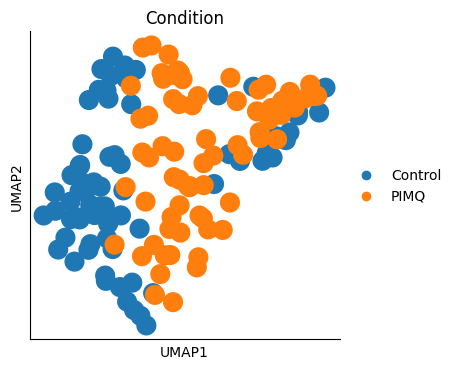

In [ ]:
# Define normalization column for size factor calculation
column_norm = 'nFrags'

def ismember(a, b):
    """Check membership of elements in a within b."""
    bind = {}
    for i, elt in enumerate(b):
        if elt not in bind:
            bind[elt] = i
    result = [bind.get(itm, None) for itm in a]
    result = [result, [not x is None for x in result]]
    return result

def norm_log_transform(adata_local, size_factors, cell_filter):
    """
    Normalize counts by size factors and apply log transformation.
    
    Parameters:
    -----------
    adata_local : AnnData
        AnnData object to normalize
    size_factors : array-like
        Size factors for normalization (e.g., total fragment counts)
    cell_filter : list
        List of cells to include (empty list means all cells)
    
    Returns:
    --------
    AnnData
        Normalized and log-transformed AnnData object
    """
    if(len(cell_filter) > 0):
        adata_local = adata_local[cell_filter,:].copy()
        size_factors = np.array(size_factors)[cell_filter]
    else:
        adata_local = adata_local.copy()
        
    print("Normalizing data")
    if(scipy.sparse.issparse(adata_local.X)):
        c = scipy.sparse.diags(1/size_factors)
        adata_local.X = c * adata_local.X * np.median(size_factors)
    else:
        adata_local.X = adata_local.X / size_factors[:,None] * np.median(size_factors)
    
    print("Log transform with pseudocount 1")
    sc.pp.log1p(adata_local)
    return(adata_local)

# Normalize peak counts by total fragment counts
ad_norm = norm_log_transform(ad_norm, ad_norm.obs[column_norm], [])

# Process gene activity scores
ad_genescores = anndata.AnnData(ad_norm.obsm['GeneScores'])

# Filter and normalize gene scores
sc.pp.filter_genes(ad_genescores, min_cells=1)
sc.pp.normalize_total(ad_genescores)
sc.pp.log1p(ad_genescores)

# Update gene scores in main object
ad_norm.obsm['GeneScores'] = ad_genescores.to_df()

# Compute neighbors from UMAP coordinates
sc.pp.neighbors(ad_norm, use_rep='X_umap')

# Visualize by condition
sc.pl.umap(ad_norm, color=['Condition'])

In [ ]:
# Load cell type annotations from single-cell peak set analysis
metadata = pd.read_csv('../intermediate_outputs3/DESeq2_files/metadata_scpeakset_D30.tsv', sep='\t')
metadata = metadata.rename(columns={'Unnamed: 0': 'SEACell'})

In [ ]:
# Display metadata to verify cell type annotations
metadata

,SEACell,n_counts,Condition,leiden,Krt5,Krt14,Krt1,Krt10,Sox9,celltype,condition_celltype
0,SEACell-0-0,499307.0,Control,5,4.532743,4.537783,4.707130,3.976965,2.751529,DB,Control_DB
1,SEACell-1-0,826952.0,Control,3,4.577361,5.434847,4.362160,3.405333,1.724380,UB,Control_UB
2,SEACell-2-0,339923.0,Control,4,4.959681,5.417159,3.398750,3.722758,2.039270,UB,Control_UB
3,SEACell-3-0,237716.0,Control,0,5.578012,4.742124,3.671797,2.761907,4.482438,uHF,Control_uHF
4,SEACell-4-0,660841.0,Control,1,4.880460,5.738469,4.374846,3.733116,2.684786,UB,Control_UB
...,...,...,...,...,...,...,...,...,...,...,...
138,SEACell-66-1,235265.0,PIMQ,0,5.189917,5.055202,2.853374,2.791865,4.089858,uHF,PIMQ_uHF
139,SEACell-67-1,399306.0,PIMQ,6,3.744345,4.637592,4.766108,3.188723,2.760480,DB,PIMQ_DB
140,SEACell-68-1,1353090.0,PIMQ,4,5.109374,5.760466,4.580454,3.886092,3.318693,UB,PIMQ_UB
141,SEACell-69-1,1290948.0,PIMQ,4,4.980414,5.640372,3.729994,3.188362,3.823291,UB,PIMQ_UB


In [ ]:
# Merge cell type annotations into metacell metadata
ad_norm.obs = ad_norm.obs.merge(metadata[['SEACell', 'leiden', 'celltype']], left_index=True, right_on='SEACell', how='left').set_index('SEACell')

In [ ]:
# Create combined condition-celltype labels for downstream analysis
ad_norm.obs['condition_celltype'] = ad_norm.obs['Condition'].astype(str) + '_' + ad_norm.obs['celltype'].astype(str)

In [ ]:
# Display metacell counts per condition and cell type
ad_norm.obs.groupby(['Condition', 'celltype']).size()

Condition  celltype
Control    DB          11
           UB          46
           uHF         15
PIMQ       DB          16
           UB          34
           uHF         21
dtype: int64

<Axes: xlabel='nFrags', ylabel='n_counts'>

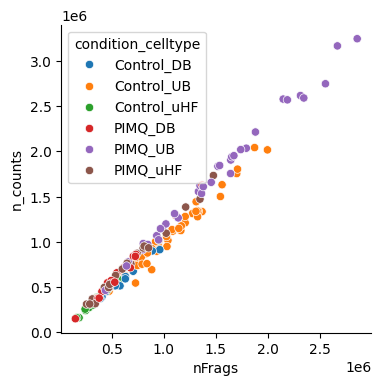

In [ ]:
# Visualize relationship between fragment counts and normalized counts
sns.scatterplot(ad_norm.obs, x='nFrags', y='n_counts', hue='condition_celltype')

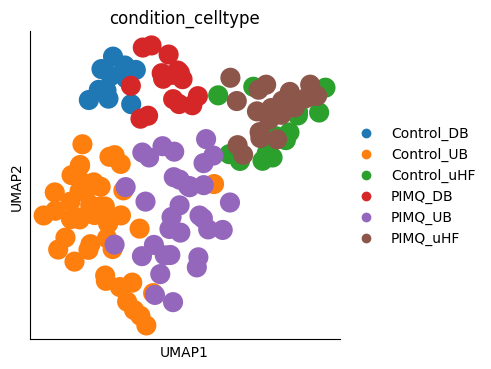

In [ ]:
# Visualize metacells by condition and cell type
sc.pl.umap(ad_norm, color='condition_celltype')

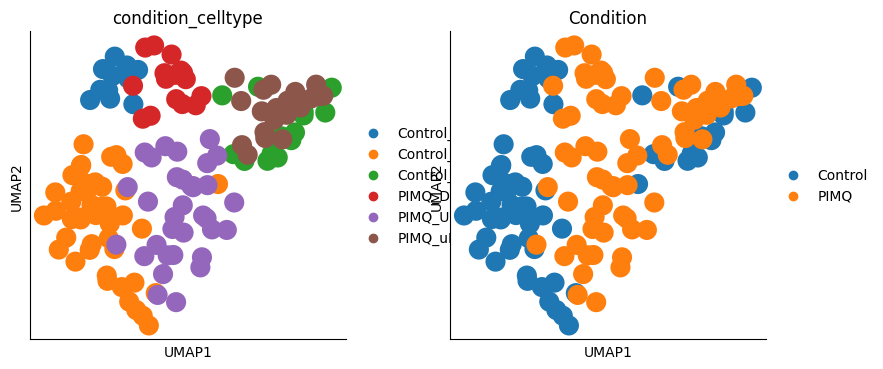

In [ ]:
# Visualize metacells colored by condition-celltype and condition
# Note: Alternative dimensionality reduction approaches are commented out
# sc.pp.highly_variable_genes(ad_norm)
# sc.tl.pca(ad_norm, n_comps=50, use_highly_variable=True)
# sc.pp.neighbors(ad_norm, n_neighbors=5)
# sc.tl.umap(ad_norm)
sc.pl.umap(ad_norm, color=['condition_celltype', 'Condition'])

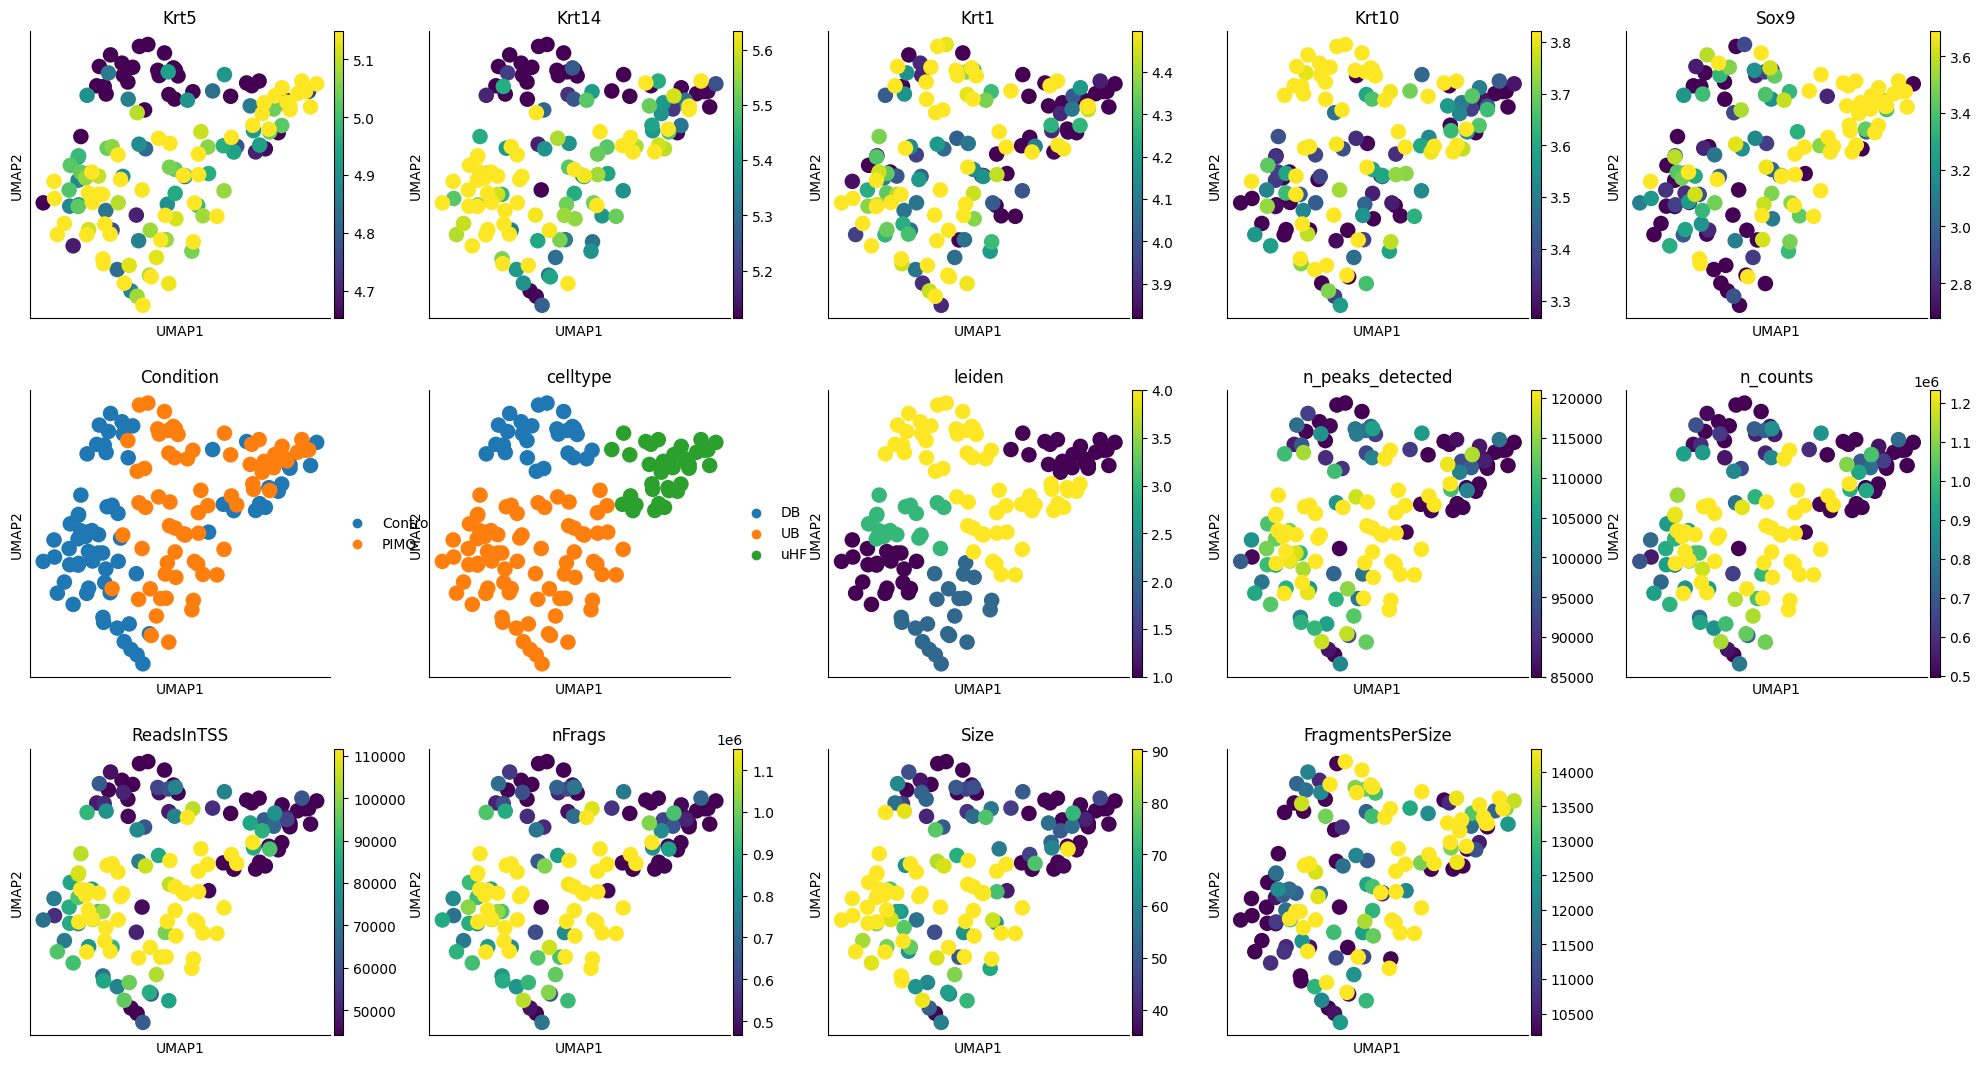

In [ ]:
# Add gene scores for key epidermal markers to observation metadata
genes_of_interest = ['Krt5', 'Krt14', 'Krt1', 'Krt10', 'Sox9']
for gene in genes_of_interest:
    if gene not in ad_norm.obs:
        try:
            ad_norm.obs[gene] = ad_norm.obsm['GeneScores'][gene]
        except:
            ad_norm.obs[gene] = 0

# Comprehensive visualization of markers and QC metrics
sc.pl.umap(ad_norm, color=genes_of_interest + ['Condition', 'celltype', 'leiden', 'n_peaks_detected', 'n_counts', 
                                                'ReadsInTSS', 'nFrags', 'Size', 'FragmentsPerSize'], 
           ncols=5, vmin='p20', vmax='p70', s=500, color_map='viridis')

In [ ]:
# Save processed D30 metacell data with non-redundant peak set
import pickle
with open('../intermediate_outputs3/sc_data/D30_nrpeakset.pickle', 'wb') as o1:
    pickle.dump(ad_norm, o1)